In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from glob import glob
import pickle

from utils import FEATURES_DIR, RESULTS_DIR
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, GLM_OUT_DIR
from notebook_utils import load_results_data, add_avg_subject

/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
all_data = load_results_data()
all_data

,alpha,model,subject,features,training_mode,testing_mode,fold,best_val_loss,best_val_acc,metric,value,ensemble,best_val_mse,model_feat
0,1000.0,bert-large-uncased,sub-01,lang,train,test,0.0,False,False,val_loss,0.949988,NaN,NaN,bert-large-uncased_lang
1,1000.0,bert-large-uncased,sub-01,lang,train,test,0.0,False,False,val_rsa,0.019661,NaN,NaN,bert-large-uncased_lang
2,1000.0,bert-large-uncased,sub-01,lang,train,test,0.0,False,False,rsa,0.135431,NaN,NaN,bert-large-uncased_lang
3,1000.0,bert-large-uncased,sub-01,lang,train,test,0.0,False,False,acc_cosine,0.804451,NaN,NaN,bert-large-uncased_lang
4,1000.0,bert-large-uncased,sub-01,lang,train,test,0.0,False,False,acc_cosine_captions,0.775155,NaN,NaN,bert-large-uncased_lang
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20508,10000000.0,vit_l_16,sub-07,vision,train,test,4.0,False,False,rsa,0.101982,NaN,NaN,vit_l_16_vision
20509,10000000.0,vit_l_16,sub-07,vision,train,test,4.0,False,False,acc_cosine,0.734058,NaN,NaN,vit_l_16_vision
20510,10000000.0,vit_l_16,sub-07,vision,train,test,4.0,False,False,acc_cosine_captions,0.681781,NaN,NaN,vit_l_16_vision
20511,10000000.0,vit_l_16,sub-07,vision,train,test,4.0,False,False,acc_cosine_images,0.836232,NaN,NaN,vit_l_16_vision


In [3]:
base_palette = sns.color_palette() + [(0, 0, 0)]
def model_feat_color_palette(data, model_feat_order):  
    model_to_color = {model: color for model, color in zip(data.model.unique(), base_palette)}
    
    new_palette = []
    prev_model = None
    feat_idx = 0
    for model_feat in model_feat_order:
        model = data[data.model_feat == model_feat].iloc[0].model
        if prev_model != model:
            prev_model = model
            feat_idx = 0
        new_color = model_to_color[model]
        new_color = [c + feat_idx*0.05 if c + feat_idx*0.1 <=1 else 1 for c in new_color]
        new_palette.append(new_color)
        feat_idx += 1
    return new_palette

In [4]:
MODEL_ORDER = ["resnet-152", "vit_l_16", "bert-large-uncased", "gpt2-xl", "visualbert", "clip", "imagebind", "lxmert", "vilt"]#flava

def calc_model_feat_order(data):
    model_feat_order = []
    all_model_feats = data.model_feat.unique()
    for model in MODEL_ORDER:
        model_feats = [mf for mf in all_model_feats if mf.startswith(model+"_")]
        while len(model_feats) > 0:
            model_feat_order.append(model_feats[0])
            all_model_feats = [mf for mf in all_model_feats if mf != model_feats[0]]
            # np.delete(all_model_feats, model_feat)
            model_feats = [mf for mf in all_model_feats if mf.startswith(model+"_")]

    #append the rest:
    model_feat_order.extend(all_model_feats)
    return model_feat_order

In [5]:
distance_metric = 'cosine'
METRICS = [f'acc_{distance_metric}', f'acc_{distance_metric}_captions', f'acc_{distance_metric}_images']

def plot_metrics(data, hue_variable="model_feat", hue_order=None, row_variable=None, metrics=METRICS, ylim=(0.5, 1), add_avg_over_subjects=True, plot_legend=True, palette=None):
    data_filtered = data[data.metric.isin(metrics)]
    if add_avg_over_subjects:
        data_filtered = add_avg_subject(data_filtered)

    sns.set_style("ticks", {'axes.grid' : True})
    g = sns.catplot(data_filtered, kind="bar", x="subject", y="value", row=row_variable, col="metric", col_order=metrics, height=6, aspect=1.7, hue=hue_variable, hue_order=hue_order, palette=palette, err_kws={'linewidth': 0.5})
    g._legend.remove()
    bbox_extra_artists = None
    if plot_legend:
        # lgd = g.fig.legend(loc='upper left', title="", bbox_to_anchor=(1, 0.9), ncol=2)
        lgd = g.fig.legend(loc='upper left', title="", bbox_to_anchor=(0.02, 0.26), ncol=7)
        bbox_extra_artists = (lgd,)

    g.set(ylim=ylim)
    
    # plt.suptitle("Test Performance", fontsize=16)
    plt.tight_layout()
    
    plt.savefig(os.path.join(RESULTS_DIR, f"{hue_variable}_comparison_{metrics[0]}.png"), bbox_extra_artists=bbox_extra_artists, bbox_inches='tight', dpi=300)
    return g, data_filtered

In [6]:
data_to_plot = all_data
MODELS_EXCLUDED = ["flava_multi"]
data_to_plot = all_data[~all_data.model_feat.isin(MODELS_EXCLUDED)]

data_to_plot = data_to_plot[(data_to_plot.best_val_acc == True) & (data_to_plot.ensemble != True)]
# data_to_plot = data_to_plot[data_to_plot.best_val_loss == True]


model_feat_order = calc_model_feat_order(data_to_plot)
palette = model_feat_color_palette(data_to_plot, model_feat_order)
# plot_metrics(data_to_plot, metrics=["rsa"], ylim=(0, 0.3))

# g, data_plotted = plot_metrics(data_to_plot, palette=palette, hue_order=model_feat_order)

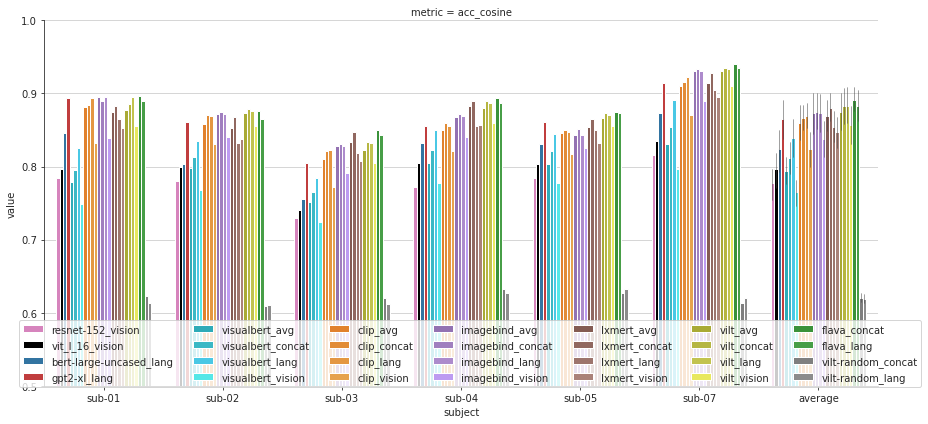

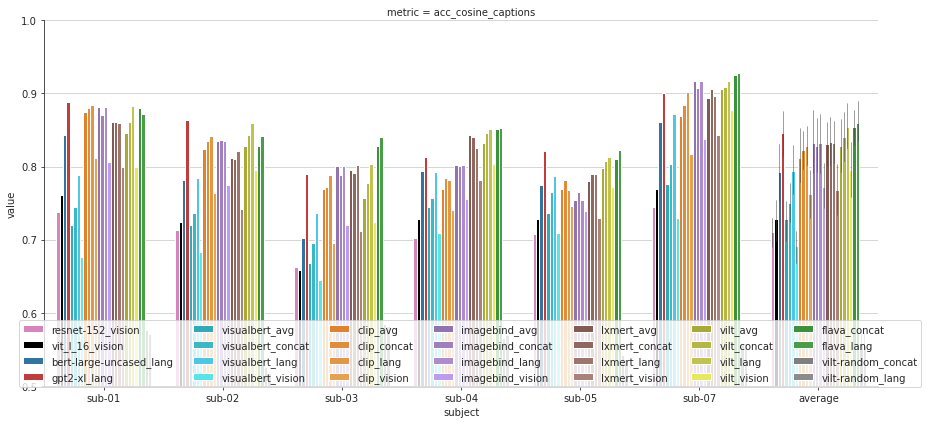

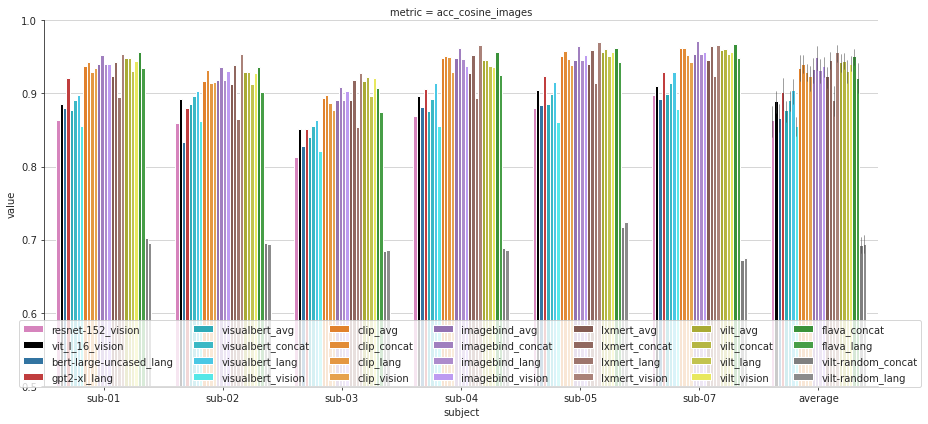

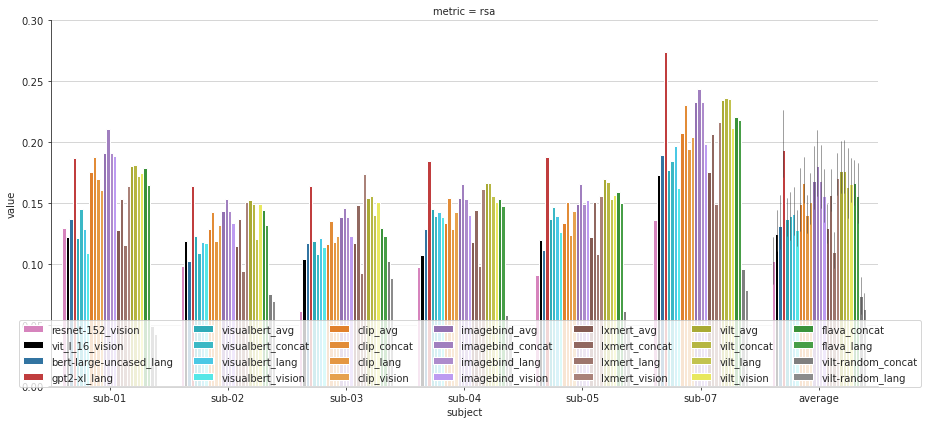

In [7]:
g, data_plotted = plot_metrics(data_to_plot, metrics=["acc_cosine"], palette=palette, hue_order=model_feat_order)
g, _ = plot_metrics(data_to_plot, metrics=["acc_cosine_captions"], palette=palette, hue_order=model_feat_order)
g, _ = plot_metrics(data_to_plot, metrics=["acc_cosine_images"], palette=palette, hue_order=model_feat_order)
g, _ = plot_metrics(data_to_plot, metrics=["rsa"], ylim=(0, 0.3), palette=palette, hue_order=model_feat_order)

In [8]:
all_data[all_data.best_val_loss == True].alpha.unique()

array([  100000., 10000000.])

In [13]:

data_to_print = all_data[(all_data.best_val_acc == True) & (all_data.ensemble != True)]
data_to_print = data_to_print[data_to_print.subject == "sub-01"]
data_to_print = data_to_print[data_to_print.model_feat.str.contains('flava_lang')]
print(len(data_to_print[data_to_print.metric == "acc_cosine"].value))
# assert len(data_to_print[data_to_print.metric == "acc_cosine"].value) == 6
print(data_to_print[data_to_print.metric == "acc_cosine"].value.mean())
data_to_print[data_to_print.metric == "acc_cosine"]

1
0.8901656314699793


,alpha,model,subject,features,training_mode,testing_mode,fold,best_val_loss,best_val_acc,metric,value,ensemble,best_val_mse,model_feat
880,100000.0,flava,sub-01,lang,train,test,NaN,NaN,True,acc_cosine,0.890166,NaN,NaN,flava_lang


In [11]:

data_to_print = all_data[(all_data.best_val_mse == True) & (all_data.ensemble != True)]
data_to_print = data_to_print[data_to_print.subject == "sub-01"]
data_to_print = data_to_print[data_to_print.model_feat.str.contains('flava_lang')]
print(len(data_to_print[data_to_print.metric == "acc_cosine"].value))
# assert len(data_to_print[data_to_print.metric == "acc_cosine"].value) == 6
print(data_to_print[data_to_print.metric == "acc_cosine"].value.mean())
data_to_print[data_to_print.metric == "acc_cosine"]

1
0.7390269151138716


,alpha,model,subject,features,training_mode,testing_mode,fold,best_val_loss,best_val_acc,metric,value,ensemble,best_val_mse,model_feat
888,10000000.0,flava,sub-01,lang,train,test,NaN,NaN,NaN,acc_cosine,0.739027,NaN,True,flava_lang
